# L12 - Data Collection and Structured Data 2
## Scraping Ethics; APIs; Reshaping and Merging

#### Announcements
* Code along with me again today!

#### Goals:
* Understand how to responsibly and ethically use web scraping to collect datasets.
* Know how to make basic usage of an API to fetch data
* Know how to reshape tables from long to wide and wide to long format
* Know how to join tables using left, right, inner, and outer joins.

# Scraping Ethics

* What does it cost you to scrape a website?
* What does it cost the person/company/entity of the website being scraped?

* Should anyone be able to scrape anything?

* Should we do a Data Ethics reading on web scraping in the AI era?

# Scraping Etiquette

Things to keep in mind:
* First, ask: can you get the data without scraping?
  * If the service provides downloadable datasets or an API, use these instead of scraping.
* Scraping public data from websites is generally OK (but I'm not a lawyer and this is not legal advice).
* Most websites will have **Terms of Service** or Terms of Use. Violating these may be illegal (but I am not a lawyer and this is not legal advice).
  * Most sites will also have a `robots.txt` which specifies how and what non-human users may access. Example: <https://www.wwu.edu/robots.txt>
* **Don't redistribute** data without permission.
* **Rate limit** your scraping requests - wait *at least* 1 second between requests (for a typical webpage); ideally more like 5-10 seconds is better.
  * `robots.txt` may specify a rate limit; respect this
  * If you don't rate limit, you are indistinguishable from a denial-of-service attack.
  * If pages are large or involve database queries on the backend, it may be polite to wait longer between queries.
* Always **save results** instead of re-requesting.
    * Save early before too much analysis is done in case you want to change your analysis.

## Using APIs

Scraping is a workaround; APIs (**application programming interfaces**) are designed to respond to programmatic requests for data.

There are many different sorts of APIs, but the gist of how to use them is:
* Construct a URL that encodes the parameters of your request
* Visit that URL in code (e.g. via Python's `requests`) or some other tool (`curl` unix command)
  * You can use a web browser, but the response generally isn't a displayable webpage.
* Get back a response in some kind of structured data format - often JSON or XML.

### API Demo
OpenWeatherMap.org has an API with a generous free usage tier - you can make up to 1000 requests per day for free.

#### API Keys and Security
To use it, you need an API key - you can register and get your own key at openweathermap.org. 

API keys should be treated like passwords - they are a secret; if I give you mine, you can burn through my 1000-request quota as quick as you like.

Even worse, many (most?) APIs are paid, either by subscription with limits or per-call. Leaking your API key could be equivalent to leaking your credit card!

I've stored mine in a file to avoid including it plaintext in this notebook:

In [60]:
API_KEY = open("/cluster/home/wehrwes/Documents/openweathermap_api_key.txt").read().strip()
BASE_URL = "http://api.openweathermap.org/data/2.5/weather"

In [61]:
import time
import json
import requests
import pandas as pd
import seaborn as sns

#### A Basic API request with Python

In [62]:
def get_weather_json(city):
    params = {
        'q': city,
        'appid': API_KEY,
        'units': 'metric'
    }
    return requests.get(BASE_URL, params=params).json()

Let's try it out:

In [63]:
seattle = get_weather_json("Seattle")
print(seattle)

{'coord': {'lon': -122.3321, 'lat': 47.6062}, 'weather': [{'id': 803, 'main': 'Clouds', 'description': 'broken clouds', 'icon': '04d'}], 'base': 'stations', 'main': {'temp': 9.89, 'feels_like': 8.06, 'temp_min': 8.46, 'temp_max': 11.04, 'pressure': 1026, 'humidity': 84, 'sea_level': 1026, 'grnd_level': 1016}, 'visibility': 10000, 'wind': {'speed': 3.6, 'deg': 200}, 'clouds': {'all': 75}, 'dt': 1761592252, 'sys': {'type': 2, 'id': 2009669, 'country': 'US', 'sunrise': 1761576372, 'sunset': 1761613193}, 'timezone': -25200, 'id': 5809844, 'name': 'Seattle', 'cod': 200}


This is an example of another structured data format called **JSON** (JavaScript Object Notation).

Similar to a Python dictionary, a JSON object represents a collection of key-value pairs. They can be nested to represent hierarchical structure similar to what we saw with XML; many people find the syntax to be a little nicer than XML.

The response came back from the API as a string, but `requests` has already parsed it into a python `dict` for us. Python has a `json` module that works with JSON to help manipulate them; here we'll use it to pretty-print the response:

In [64]:
print(json.dumps(seattle, indent=2))

{
  "coord": {
    "lon": -122.3321,
    "lat": 47.6062
  },
  "weather": [
    {
      "id": 803,
      "main": "Clouds",
      "description": "broken clouds",
      "icon": "04d"
    }
  ],
  "base": "stations",
  "main": {
    "temp": 9.89,
    "feels_like": 8.06,
    "temp_min": 8.46,
    "temp_max": 11.04,
    "pressure": 1026,
    "humidity": 84,
    "sea_level": 1026,
    "grnd_level": 1016
  },
  "visibility": 10000,
  "wind": {
    "speed": 3.6,
    "deg": 200
  },
  "clouds": {
    "all": 75
  },
  "dt": 1761592252,
  "sys": {
    "type": 2,
    "id": 2009669,
    "country": "US",
    "sunrise": 1761576372,
    "sunset": 1761613193
  },
  "timezone": -25200,
  "id": 5809844,
  "name": "Seattle",
  "cod": 200
}


In [ ]:
with open("seattle_json.csv", "w") as f:
    json.dump(seattle, f)

In [ ]:
# if you didn't make the API call, use this to load up a sample JSON result:
seattle = requests.get("https://facultyweb.cs.wwu.edu/~wehrwes/courses/data311_25f/lectures/L12/seattle_json.csv").json()

Since it's just a `dict`, we can access things using familiar dictionary indexing syntax:

In [67]:
# get the temperature
seattle["main"]["temp"]

9.89

**Exercise**: get the wind speed

In [69]:
seattle["wind"]["speed"]

3.6

Now let's use this to build a little dataset of weather for a few cities:

In [70]:
cities = ["Seattle", "Los Angeles", "London", "Paris", "Tokyo", "Sydney", "New York"]

# Fetch current weather for multiple cities
data = {}
for city in cities:
    data[city] = get_weather_json(city)

    time.sleep(1)

In [71]:
data_table = []
for city, resp in data.items():
    data_table.append({
            'city': city,
            'temp': resp['main']['temp'],
            'feels_like': resp['main']['feels_like'],
            'humidity': resp['main']['humidity']
        })

In [72]:
df_orig = pd.DataFrame(data_table)
df_orig

city   temp  feels_like  humidity
0      Seattle   9.90        8.07        84
1  Los Angeles  21.16       21.19        71
2       London  11.75       10.81        70
3        Paris  11.01       10.23        79
4        Tokyo  15.73       14.77        54
5       Sydney  13.06       12.22        69
6     New York  13.30       11.83        44

## Reshaping Data Tables: Long format vs Wide Format

When dealing with tabular data, there's a notion of "wide" vs "long" format.

The table we've built is considered **wide** because each property occupies a column:

In [73]:
df_wide = df_orig.set_index('city')
df_wide

temp  feels_like  humidity
city                                    
Seattle       9.90        8.07        84
Los Angeles  21.16       21.19        71
London       11.75       10.81        70
Paris        11.01       10.23        79
Tokyo        15.73       14.77        54
Sydney       13.06       12.22        69
New York     13.30       11.83        44

If we want to plot one column, for example, this is great:

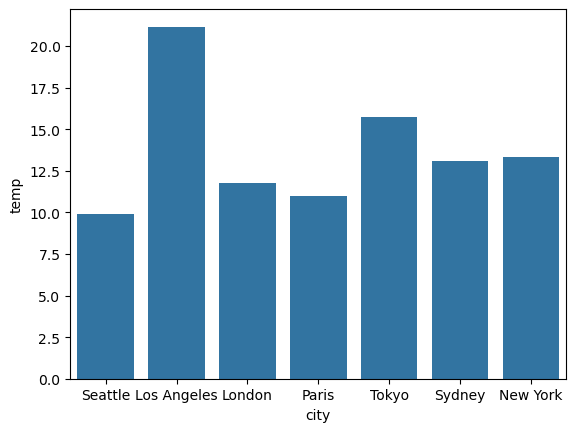

In [74]:
sns.barplot(df_wide["temp"]);

If we want to plot them all alongside each other, Seaborn doesn't do what we really want:

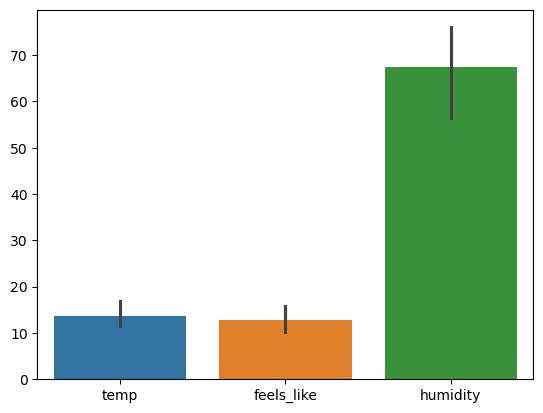

In [75]:
sns.barplot(data=df_wide);

Sometimes it's useful to convert to **long** format, where the values all live in one column and the properties (formerly column names) are a categorical column.

In pandas, we do this with `melt`.

Here, the parameters are:
* `id_vars`, the thing we want to keep as a per-row thing; this can be more than one column!
* `var_name` is the name of the categorical column that will contain the other column names
* `value_name` is the name of the numerical column with the values of the properties in the `var_name` column.
Sound confusing? Example:

In [84]:
df_long = df_orig.melt(id_vars=['city'],
                       value_vars=["temp", "feels_like", "humidity"],
                       var_name='metric', value_name='value')
df_long

city      metric  value
0       Seattle        temp   9.90
1   Los Angeles        temp  21.16
2        London        temp  11.75
3         Paris        temp  11.01
4         Tokyo        temp  15.73
5        Sydney        temp  13.06
6      New York        temp  13.30
7       Seattle  feels_like   8.07
8   Los Angeles  feels_like  21.19
9        London  feels_like  10.81
10        Paris  feels_like  10.23
11        Tokyo  feels_like  14.77
12       Sydney  feels_like  12.22
13     New York  feels_like  11.83
14      Seattle    humidity  84.00
15  Los Angeles    humidity  71.00
16       London    humidity  70.00
17        Paris    humidity  79.00
18        Tokyo    humidity  54.00
19       Sydney    humidity  69.00
20     New York    humidity  44.00

Why would we want this? it might be more flexible for certain kinds of analysis (think group_by->aggregate, maybe)?

Also, Seaborn:

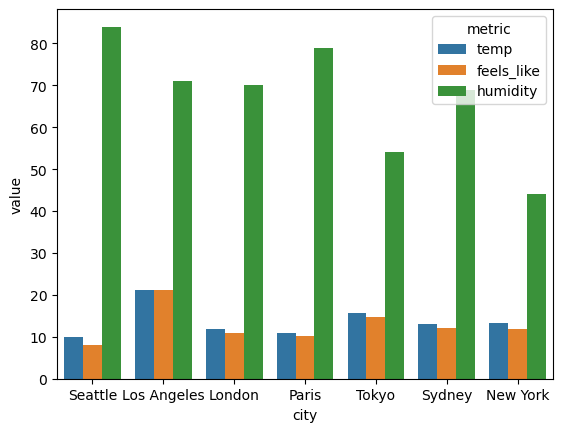

In [77]:
sns.barplot(data=df_long, x='city', y='value', hue='metric');

If you have long data and want wide data, you can use **pivot**:

In [82]:
# long to wide
df_long.pivot(index="city", columns="metric", values="value")

metric       feels_like  humidity   temp
city                                    
London            10.81      70.0  11.75
Los Angeles       21.19      71.0  21.16
New York          11.83      44.0  13.30
Paris             10.23      79.0  11.01
Seattle            8.07      84.0   9.90
Sydney            12.22      69.0  13.06
Tokyo             14.77      54.0  15.73

### Exercise: tips dataset

In [85]:
tips = sns.load_dataset('tips')
tips.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

**Exercise**: Use `melt` to stack `total_bill` and `tip` into one column so you can plot both on the same chart with different colors. Leave the other columns alone.

In [90]:
tips_long = tips.melt(id_vars=["day"],
                      value_vars=["total_bill", "tip"],
                      var_name="amount_type", value_name="dollars")
tips_long

day amount_type  dollars
0     Sun  total_bill    16.99
1     Sun  total_bill    10.34
2     Sun  total_bill    21.01
3     Sun  total_bill    23.68
4     Sun  total_bill    24.59
..    ...         ...      ...
483   Sat         tip     5.92
484   Sat         tip     2.00
485   Sat         tip     2.00
486   Sat         tip     1.75
487  Thur         tip     3.00

[488 rows x 3 columns]

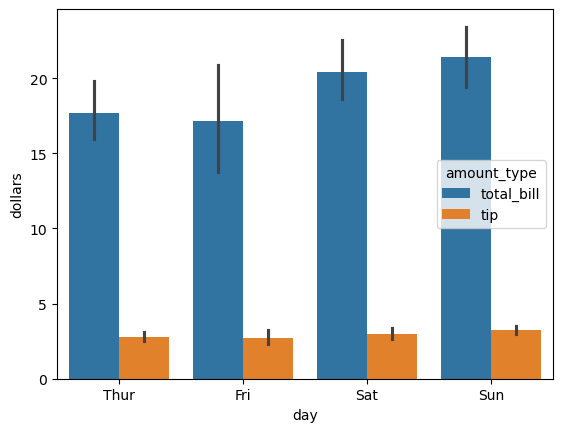

In [87]:
sns.barplot(data=tips_long, x='day', y='dollars', hue='amount_type');

### Exercise / Example: Flights dataset

In [91]:
flights = sns.load_dataset('flights')
flights

year month  passengers
0    1949   Jan         112
1    1949   Feb         118
2    1949   Mar         132
3    1949   Apr         129
4    1949   May         121
..    ...   ...         ...
139  1960   Aug         606
140  1960   Sep         508
141  1960   Oct         461
142  1960   Nov         390
143  1960   Dec         432

[144 rows x 3 columns]

This dataset comes in **long** format!

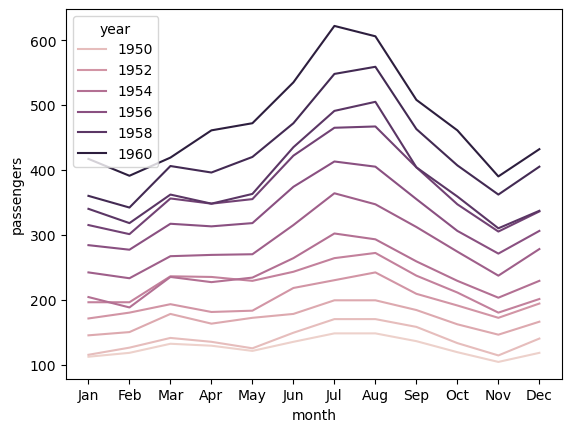

In [92]:
sns.lineplot(data=flights, x="month", y="passengers", hue="year");

**Exercise**: Convert it to **wide** format using `pivot`. If we use `year` as the index, make one column per `month`, and have the table contain passengert counts for each year/month pair, we can plot a heatmap of the passenger counts over the years.

In [93]:
#flights_wide = ...
flights_wide

NameError: name 'flights_wide' is not defined

In [ ]:
sns.heatmap(flights_wide, annot=True, fmt='d')

## Merging Tables

Sometimes you have multiple tables with complementary information - this will happen in Lab 5, where we'll scrape two different sites for different info about (some of) the same movies.

How do we combine tables together? `pd.merge`.



In [94]:
employees = pd.DataFrame({
    'emp_id': [1, 2, 3, 4],
    'name': ['Alice', 'Bob', 'Charlie', 'Diana'],
    'dept_id': [10, 20, 10, 30]
})
employees

emp_id     name  dept_id
0       1    Alice       10
1       2      Bob       20
2       3  Charlie       10
3       4    Diana       30

In [95]:
departments = pd.DataFrame({
    'dept_id': [10, 20, 40],
    'dept_name': ['Engineering', 'Sales', 'Marketing']
})
departments

dept_id    dept_name
0       10  Engineering
1       20        Sales
2       40    Marketing

In [96]:
# INNER JOIN - Only employees with valid departments
employees.merge(departments, on='dept_id', how='inner')

emp_id     name  dept_id    dept_name
0       1    Alice       10  Engineering
1       2      Bob       20        Sales
2       3  Charlie       10  Engineering

In [97]:
# LEFT JOIN - All employees, even if department missing
employees.merge(departments, on='dept_id', how='left')

emp_id     name  dept_id    dept_name
0       1    Alice       10  Engineering
1       2      Bob       20        Sales
2       3  Charlie       10  Engineering
3       4    Diana       30          NaN

In [98]:
# RIGHT JOIN - All departments, even if no employees
employees.merge(departments, on='dept_id', how='right')

emp_id     name  dept_id    dept_name
0     1.0    Alice       10  Engineering
1     3.0  Charlie       10  Engineering
2     2.0      Bob       20        Sales
3     NaN      NaN       40    Marketing

In [99]:
# OUTER JOIN - Everything from both tables
employees.merge(departments, on='dept_id', how='outer')

emp_id     name  dept_id    dept_name
0     1.0    Alice       10  Engineering
1     3.0  Charlie       10  Engineering
2     2.0      Bob       20        Sales
3     4.0    Diana       30          NaN
4     NaN      NaN       40    Marketing

**Exercise**: I have two CSV files from my CSCI 141 class; one is from the start-of-quarter survey, and one is the final gradebook.

On the start-of-quarter survey (in a dataframe `survey`), students reported how many months of programming experience they had. Some students added the class late, and are not present in the survey results.

The gradebook (in a DataFrame `grades`) has all the grades for the quarter. Some students who dropped the course after the first week are not included are not included in the gradebook.

Both files have the following columns:
* Name (in Last, First format)
* W number
* Email address

I want to analyze the relationship between programming experience and final grades, so I can run something like

```
sns.scatter(data=combined, x="Months Experience", y="Final Grade")
```

How should I construct the `combined` dataframe that will enable this?